In [1]:
import argparse
import json

import numpy as np
import requests
import keras
from keras.applications import inception_v3
from keras.preprocessing import image

import tensorflow as tf

import sys
import os
import cv2
import matplotlib.pyplot as plt
import pickle

sys.path.append(os.path.dirname("../../ssd_detectors/"))

Using TensorFlow backend.


# Seglink

In [2]:
from sl_model import SL512

# SegLink
model = SL512(input_shape=(512, 512, 3), softmax=True)
weights_path= "../../ssd_detectors/checkpoints/sl512_ksignboard_ex18/weights.240.h5"

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
[t.name for t in  model.inputs]

['input_1:0']

In [4]:
[t.name for t in  model.outputs]

['predictions/concat:0']

model.save('seglink_ksignboard_final.h5')

In [ ]:
export_path = 'seglink_ksignboard/1'

with tf.keras.backend.get_session() as sess:
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess.run(init_op)
    model.load_weights(weights_path)
    tf.saved_model.simple_save(sess, export_path, inputs={t.name: t for t in model.inputs}, outputs={t.name: t for t in model.outputs})


# CRNN

In [2]:
from crnn_model_focal_ctc_loss import CRNN
from util.crnn_utils import dict838

input_width = 256
input_height = 32
input_shape = (input_width, input_height, 1)

In [3]:
model, model_pred = CRNN(input_shape, len(dict838),prediction_only=False, gru=False)

Instructions for updating:
Colocations handled automatically by placer.


/home/ina/anaconda3/envs/ina/lib/python3.7/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


In [4]:
[t.name for t in  model.inputs]

['image_input:0', 'label_input:0', 'input_length:0', 'label_length:0']

In [5]:
[t.name for t in  model_pred.inputs]

['image_input:0']

## train model save

In [ ]:
from keras.optimizers import SGD

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

In [8]:
model.load_weights("../../ssd_detectors/checkpoints/201905061732_crnn_ksignboard_v18_best_3/weights.053.h5",by_name=True)

In [1]:
model.save('crnn_test2.h5')

NameError: name 'model' is not defined

In [ ]:
#model_pred = tf.keras.models.load_model('crnn_test.h5')

In [8]:
export_path = '../crnn/1'

with tf.keras.backend.get_session() as sess:
    #init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    #sess.run(init_op)
    model_pred.load_weights("../../ssd_detectors/checkpoints/201905061732_crnn_ksignboard_v18_best_3/weights.053.h5",by_name=True)
    tf.saved_model.simple_save(sess, export_path, inputs={t.name: t for t in model_pred.inputs}, outputs={t.name: t for t in model_pred.outputs})


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ../crnn/1/saved_model.pb


## test model save

In [ ]:
model_pred.load_weights("../../ssd_detectors/checkpoints/201905061706_crnn_ksignboard_v18_best/weights.037.h5",by_name=True)

In [ ]:
model_pred.get_layer

In [ ]:
model_pred.save('crnn_ksignboard_final.h5')

In [ ]:
from data_cracker import GTUtility

file_name = '../../ssd_detectors/gt_util_merge_data.pkl'

with open(file_name, 'rb') as f:
    gt_util_cracker = pickle.load(f)

In [ ]:
gt_util_train, gt_util_val = GTUtility.randomSplit(gt_util_cracker)

In [ ]:
from crnn_data_fcl_aug_merge import InputGenerator

In [ ]:
batch_size = 32
max_string_len = 62
gen_train = InputGenerator(gt_util_train, batch_size, dict838, input_shape[:2], 
                           grayscale=True, max_string_len=max_string_len)
gen_val = InputGenerator(gt_util_val, batch_size, dict838, input_shape[:2], 
                         grayscale=True, max_string_len=max_string_len)

In [ ]:
g = gen_train.generate()

In [ ]:
d = next(g)

## loading and serve model

In [ ]:
#model = tf.keras.models.load_model('CRNN.h5',custom_objects={'<lambda>': lambda y_true, y_pred: y_pred})
model_pred = tf.keras.models.load_model('crnn_ksignboard_final.h5')

In [ ]:
export_path = '../crnn/1'

with tf.keras.backend.get_session() as sess:
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess.run(init_op)
    model_pred.load_weights("../../ssd_detectors/checkpoints/201905061706_crnn_ksignboard_v18_best/weights.037.h5")
    tf.saved_model.simple_save(sess, export_path, inputs={t.name: t for t in model_pred.inputs}, outputs={t.name: t for t in model_pred.outputs})


In [ ]:
model.summary()

## inception

In [ ]:
model = tf.keras.models.load_model('./scripts/inception.h5')

In [ ]:
model.summary()

In [ ]:
{t.name for t in model.inputs}

In [ ]:
with tf.keras.backend.get_session() as sess:
        outputs={t.name: t for t in model.outputs}
        print(outputs)

# seglink

In [12]:
image_path = "/home/ina/Documents/ssd_detectors/data/COCO-TEXT/train2014/COCO_train2014_000000002007.jpg"
image_path = "/home/ina/Documents/ssd_detectors/data/KSIGNBOARD/21107_22.jpg"
seg_img = image.img_to_array(image.load_img(image_path, target_size=(512, 512)))
# seglink : input_1:0

In [ ]:
seg_img.

In [15]:
image_path = "/home/ina/Documents/ssd_detectors/data/KSIGNBOARD/20899_22.jpg"
input_image = cv2.imread(image_path)
seg_img = cv2.resize(input_image, (512,512), cv2.INTER_AREA)

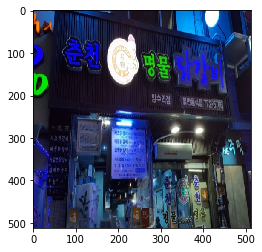

In [17]:
import matplotlib.pyplot as plt

plt.imshow(seg_img)


In [18]:
payload = {
    "instances": [{'input_1:0': seg_img.tolist()}]
}

In [19]:
r = requests.post('http://localhost:9002/v1/models/seglink:predict', json=payload)

In [20]:
r

<Response [200]>

In [21]:
pred = json.loads(r.content.decode('utf-8'))
res = np.array(pred['predictions'])[0]

In [22]:
res.shape

(5461, 31)

In [23]:
res

array([[ 0.949294 ,  0.0507063,  0.33227  , ...,  0.536719 ,  0.308723 ,
         0.691277 ],
       [ 0.958778 ,  0.041222 ,  0.0393196, ...,  0.403892 ,  0.531377 ,
         0.468623 ],
       [ 0.94633  ,  0.0536699, -0.497729 , ...,  0.347225 ,  0.504306 ,
         0.495694 ],
       ...,
       [ 0.87704  ,  0.12296  ,  0.373241 , ...,  0.0938755,  0.918279 ,
         0.0817209],
       [ 0.871325 ,  0.128675 , -0.152396 , ...,  0.0912126,  0.908476 ,
         0.0915244],
       [ 0.950195 ,  0.0498055, -0.364633 , ...,  0.0765723,  0.923758 ,
         0.0762422]])

In [24]:
from util import sl_util

prior_util = sl_util.PriorUtil()

In [25]:
segment_threshold = 0.4; link_threshold = 0.25
res = prior_util.decode(res, segment_threshold, link_threshold, debug=False)

In [26]:
res.shape # (boxes, x+y+w+h+theta+conf(6)) 

(11, 6)

In [27]:
len(res)

11

In [28]:
box = res[0][:5]

In [29]:
from utils.bboxes import rbox_to_polygon

In [30]:
xy_rec = rbox_to_polygon(box)
xy_rec

array([[ 45.94028543, 308.96101065],
       [ 57.97834397, 309.18831621],
       [ 58.29302457, 292.52289215],
       [ 46.25496603, 292.29558659]])

In [31]:
xylist = []
for b in range(len(res)):
    xy_rec = rbox_to_polygon(res[b][:5])
    xy=[]
    for i in range(4):
        for idx in range(2):
            xy.append(xy_rec[i][idx])
    xy_r = [r/512 for r in xy]
    xylist.append(xy_r)

In [32]:
from util import crop_word

In [33]:
words = crop_word.crop_words(seg_img, xylist)

In [34]:
words

[array([[[38.],
         [30.],
         [27.],
         ...,
         [ 1.],
         [ 1.],
         [ 1.]],
 
        [[46.],
         [34.],
         [27.],
         ...,
         [ 1.],
         [ 1.],
         [ 1.]],
 
        [[53.],
         [38.],
         [23.],
         ...,
         [ 1.],
         [ 1.],
         [ 1.]],
 
        ...,
 
        [[15.],
         [19.],
         [19.],
         ...,
         [ 1.],
         [ 1.],
         [ 1.]],
 
        [[11.],
         [15.],
         [19.],
         ...,
         [ 1.],
         [ 1.],
         [ 1.]],
 
        [[11.],
         [11.],
         [15.],
         ...,
         [ 1.],
         [ 1.],
         [ 1.]]]), array([[[ 31.],
         [ 21.],
         [ 14.],
         ...,
         [  1.],
         [  1.],
         [  1.]],
 
        [[ 28.],
         [ 24.],
         [ 10.],
         ...,
         [  1.],
         [  1.],
         [  1.]],
 
        [[ 31.],
         [ 24.],
         [ 14.],
         ...,
     

In [35]:
words = np.asarray(words)
words.shape

(11, 32, 256, 1)

In [36]:
len(words)

11

In [37]:
images = np.ones([len(words), 256, 32, 3])
for j in range(len(words)):
    images[j] = words[j].transpose(1,0,2)

In [38]:
images.shape

(11, 256, 32, 3)

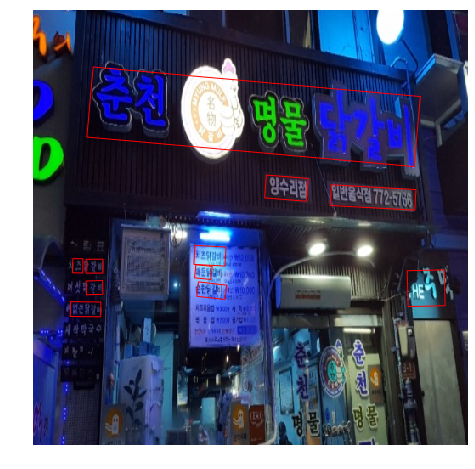

In [39]:
plt.figure(figsize=[8]*2)
plt.imshow(seg_img)
prior_util.plot_results(res)
plt.axis('off')
plt.show()

## To tf serving (CRNN)

In [5]:
img.shape

(480, 640, 3)

In [39]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [40]:
img = image.img_to_array(images[2])
img = rgb2gray(img)
img = np.expand_dims(img,-1)

In [41]:
import matplotlib.pyplot

In [42]:
images[2].shape

(256, 32, 3)

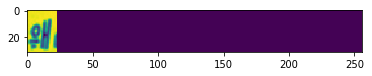

In [51]:
plt.imshow(images[3][:,:,0].T)

In [ ]:
"""
image_path = "/home/ina/Documents/ssd_detectors/data/COCO-TEXT/train2014/COCO_train2014_000000002007.jpg"

img = image.img_to_array(image.load_img(image_path, target_size=(256, 32))) / 255.
img = rgb2gray(img)
img = np.expand_dims(img,-1)
"""
# crnn : image_input:0

In [ ]:
img.shape

In [ ]:
payload = {
    "instances": [{'image_input_1:0': img.tolist()}]
}

In [ ]:
r = requests.post('http://localhost:9002/v1/models/crnn:predict', json=payload)

In [ ]:
r

In [ ]:
pred = json.loads(r.content.decode('utf-8'))

In [ ]:
res = np.array(pred['predictions'])[0]

In [ ]:
res.shape

In [ ]:
from util.crnn_utils import dict838 as dic
from util.crnn_utils import decode

chars = [dic[c] for c in np.argmax(res,axis=1)]
res_str = decode(chars)

In [ ]:
res_str

In [ ]:
import pickle
file_name = '/home/primadonna/Documents/ssd_detectors/gt_util_cocotext.pkl'

with open(file_name, 'rb') as f:
    gt_util = pickle.load(f)

In [ ]:
from crnn_utils import alphabet87 as alphabet
input_width = 256
input_height = 32
input_shape = (input_width, input_height, 1)
batch_size = 1
max_string_len = 62

In [ ]:
from crnn_data import InputGenerator

gen_val = InputGenerator(gt_util, batch_size, alphabet, input_shape[:2],
                         grayscale=True, max_string_len=max_string_len)

In [ ]:
g = gen_val.generate()

In [ ]:
d = next(g)
img = d[0]['image_input']
img[0].shape

In [ ]:
d[0]['source_str']

In [ ]:
payload = {
    "instances": [{'image_input:0': img[0].tolist()}]
}

In [ ]:
r = requests.post('http://localhost:9000/v1/models/ImageClassifier:predict', json=payload)

In [ ]:
r

In [ ]:
pred = json.loads(r.content.decode('utf-8'))

In [ ]:
res = np.array(pred['predictions'])[0]

In [ ]:
res.shape

In [ ]:
from crnn_utils import decode
from crnn_utils import alphabet87 as alphabet

chars = [alphabet[c] for c in np.argmax(res,axis=1)]
res_str = decode(chars)

In [ ]:
res_str